In [1]:
import numpy as np
import pandas as pd
import random

from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from skimage.transform import resize
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import albumentations as A

from pathlib import Path
# import SimpleITK as sitk
# import pydicom
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# import cv2

/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data preprocessing

In [2]:
df = pd.read_csv('../zhout/Documents/cleaned_merged_radio_clinical.csv')
df.shape

/tmp/ipykernel_32341/750618810.py:1: DtypeWarning: Columns (23,24,25,64,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../zhout/Documents/cleaned_merged_radio_clinical.csv')


(8407, 1096)

In [3]:
df['ROI'] = df['ROI'].apply(lambda x: ''.join(x.split()).lower())
df = df.drop(columns=['ID','PiCare MetID',
                      'PiCare PatientID',
                      'Failure-eventFreeTime',
                      'Follow-up time',
                      'Date of last follow-up',
                      'ARE Yes/No',
                      'Date primary diag',
                      'Date met diag',
                      'ROIname',
                      'Date of birth'])
rep_cols = [c for c in df.columns if c.endswith('.1')]
df = df.drop(columns = rep_cols)
df.shape

(8407, 1055)

In [4]:
# correlation = df.corr()
# variable_corr =np.abs(correlation.iloc[0][1:]).sort_values(ascending=False)
# variable_corr

LesionCount                                                     0.418147
texture_gldzm_3D_scale2_algoFBNequal256_bin32_Fdzm_z_perc       0.181997
texture_glszm_3D_scale2_algoFBNequal256_bin32_Fszm_z_perc       0.181997
texture_gldzm_3D_scale2_algoFBN_bin32_Fdzm_sde                  0.180553
Vol in 10 Gy line                                               0.179363
                                                                  ...   
texture_ngtdm_3D_scale4_algoFBNequal256_bin8_Fngt_complexity    0.000771
texture_glszm_3D_scale4_algoFBNequal256_bin64_Fszm_lzhge        0.000347
intHist_3D_scale2_algoFBN_bin64_Fih_max                              NaN
intHist_3D_scale2_algoFBN_bin64_Fih_min                              NaN
intHist_3D_scale2_algoFBN_bin64_Fih_range                            NaN
Name: Failure-binary, Length: 928, dtype: float64

In [5]:
def to_null_df(df):
    n = len(df)
    null_col = []
    for i in df.columns:
        na = df[i].isnull().sum()
        null_col.append([i,na,na/n])
    null_df = pd.DataFrame(null_col,columns=['column','null_num','null_ratio'])
    return null_df

In [6]:
def select_via_null(null_df,df,ratio = 0.1):
    selected_cols = null_df[null_df['null_ratio']<ratio]['column']
    return df[selected_cols].dropna()

In [7]:
def date_to_int(df,col):
    return df[col].str.replace("-","").astype(int)

def label_encoding_with_NAs(data,col):
    data[col] = data[col].astype('category').cat.as_ordered()
    encoder = data[col].cat.categories
#    print("--- Encoding column ",col)
    # leaving 0 for NAs
    data[col] = data[col].cat.codes + 1

In [8]:
def encode_date(df_slt):
    dcol = []
    for col in df_slt.columns:
        if col.startswith('Date'):
            dcol.append(col)
    if 'Date primary diag' in dcol:
        df_slt['Date primary diag']=df_slt['Date primary diag'].apply(lambda x: x.split()[0])

    for col in dcol:
#         print(col,df_slt[col].iloc[0])
        df_slt[col] = date_to_int(df_slt,col)
#         print(col,df_slt[col].iloc[0])
    print(f'--date encoded {len(dcol)} columns')

In [9]:
def encode_all(df_slt):
    i = 0
    for col,dtype in zip(df_slt.columns,df_slt.dtypes):
        if dtype=='object':
            label_encoding_with_NAs(df_slt,col)
            i+=1

    print (f'--label encoded {i} columns')
    return df_slt

In [10]:
def split_target(df, target):
    Y = df[target].values
    X = df.drop(columns=[target])
    return X, Y

In [11]:
## Oversample or undersample
def resampling(X,y,sampling = 'oversample',ratio = 0.4):
    if sampling =='oversample':
        resample = SMOTE(sampling_strategy = ratio)
    elif sampling =='undersample':
        resample = RandomUnderSampler(sampling_strategy=ratio)
        
    return resample.fit_resample(X,y)

In [12]:
def data_processing(df,null_ratio = 0.1):
    print(f'The data size before processing is {df.shape}.')
    null_df = to_null_df(df)
    df_slt = select_via_null(null_df,df,ratio = null_ratio)
    encode_date(df_slt)
    df_slt = encode_all(df_slt)
    X,y = split_target(df_slt,'Failure-binary')
    print(f'The data size after processing is X: {X.shape}, y: {y.shape}.\n')
    return X,y

In [13]:
X,y = data_processing(df)

The data size before processing is (8407, 1055).
--date encoded 1 columns
--label encoded 60 columns
The data size after processing is X: (6692, 374), y: (6692,).



In [49]:
!pwd

/home/zengy


# 2. Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,recall_score,precision_score,log_loss,f1_score
import pickle

### 2.1 Functions

In [15]:
def Random_search_gbr_cv(X,y):
    
    max_depth = [int(x) for x in np.linspace(5, 20, num = 15)]
    max_features = [x for x in np.linspace(0.1, 0.8, num = 15)]
    min_samples_leaf = [int(x) for x in np.linspace(5, 20, num = 15)]
    learning_rate = [x for x in np.linspace(0.01,0.1, num = 15)]

    random_grid = {'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf,
                   'learning_rate':learning_rate}

    gbr = GradientBoostingClassifier(n_estimators=100)

    gbr_random = RandomizedSearchCV(estimator = gbr, 
                                   param_distributions = random_grid,
                                   scoring = 'f1_weighted',
                                   n_iter = 10, 
                                   random_state=42, 
                                   verbose=1, 
                                   n_jobs = -1)

    gbr_random.fit(X,y)

    
    #Get the 'best' hyperparameter and fit all the data
    h1 = gbr_random.best_params_['min_samples_leaf']
    h2 = gbr_random.best_params_['max_features']
    h3 = gbr_random.best_params_['max_depth']
    h4 = gbr_random.best_params_['learning_rate']

    return h1,h2,h3,h4

In [16]:
def get_metrics(model,X_test,y_test):
    y_proba = model.predict_proba(X_test)
    y_hat = model.predict(X_test)
    result = (roc_auc_score(y_test,y_proba[:,1]),
              recall_score(y_test,y_hat),
              precision_score(y_test,y_hat),
              log_loss(y_test,y_proba[:,1]),
              f1_score(y_test,y_hat),
              model.score(X_test,y_test))
    print(f""" Results:
              The ROC_AUC score is {result[0]:.4f}. 
              The recall score is {result[1]:.4f}. 
              The Precision score is {result[2]:.4f}. 
              The Accuracy is {result[5]:.4f}.
              The log loss is {result[3]:.4f}. 
              The f1 score is {result[4]:.4f}.""")
    return result

In [17]:
def run_model(df,sampling = 'oversample',sampling_ratio = 0.5):
    "sampling = 'oversample'|'undersample'|'none'"
    X,y = data_processing(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    print(f'The traing data size before resampling is {X_train.shape}')
    if sampling != 'none':
        X_train,y_train = resampling(X_train,y_train,sampling = sampling,ratio = sampling_ratio)
        print(f'The traing data size after resampling is {X_train.shape}')
        
    print('\n--fitting cross validation..')
    h1,h2,h3,h4 = Random_search_gbr_cv(X_train,y_train)
    
    print('\n--fitting the final model..')
    gb =  GradientBoostingClassifier(n_estimators=100, 
                               min_samples_leaf=h1,
                               max_features=h2, 
                               max_depth=h3,
                               learning_rate = h4,
                               verbose=0)

    gb.fit(X_train,y_train)
    result = get_metrics(gb,X_test,y_test)
    return gb,result,(X_train, X_test, y_train, y_test)

In [18]:
def featimp(model,data,plot = True):
    imp_all = {n:s for n,s in zip(data[0].columns, model.feature_importances_)}
    imp_all = sorted(imp_all.items(), key =lambda x:x[1],reverse=True)
    c = [i[0] for i in imp_all[:10]]
    v = [i[1] for i in imp_all[:10]]
    if plot == True:
        plt.figure(figsize=(7,5))
        sns.set_theme(style="whitegrid")
        sns.set_color_codes("pastel")
        sns.barplot(v,c, orient = "h",color = 'b')
        plt.show()
    return c[:6]

In [19]:
def red_model(df, model,data,sampling = 'oversample',plot = True, sampling_ratio = 0.5):
    col = featimp(model,data,plot = plot)
    col.append('Failure-binary')
    model,result,data = run_model(df[col],sampling=sampling, sampling_ratio = sampling_ratio)
    return model, result, data

# 3. ALL DATA
## 3.1 Without sampling

In [20]:
gb_all,result_all,data_all = run_model(df,sampling='none')

The data size before processing is (8407, 1055).
--date encoded 1 columns
--label encoded 60 columns
The data size after processing is X: (6692, 374), y: (6692,).

The traing data size before resampling is (5019, 374)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8060. 
              The recall score is 0.2711. 
              The Precision score is 0.7895. 
              The Accuracy is 0.9205.
              The log loss is 0.2662. 
              The f1 score is 0.4036.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


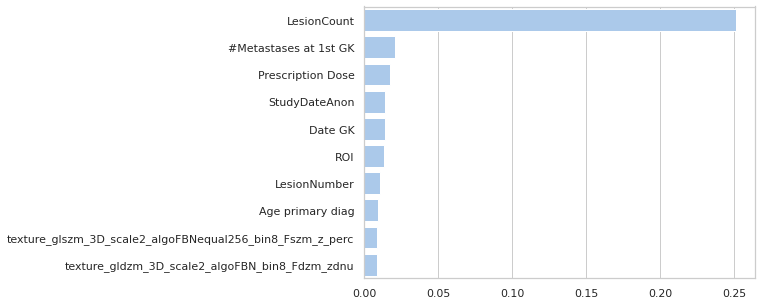

The data size before processing is (8407, 7).
--date encoded 1 columns
--label encoded 2 columns
The data size after processing is X: (8345, 6), y: (8345,).

The traing data size before resampling is (6258, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8699. 
              The recall score is 0.2984. 
              The Precision score is 0.7500. 
              The Accuracy is 0.9267.
              The log loss is 0.2184. 
              The f1 score is 0.4270.


In [21]:
gb_allred,result_allred,data_allred = red_model(df,gb_all,data_all,sampling = 'none')

## 3.2 ALL DATA: Oversample

In [22]:
gb_allo,result_allo,data_allo = run_model(df,sampling='oversample')

The data size before processing is (8407, 1055).
--date encoded 1 columns
--label encoded 60 columns
The data size after processing is X: (6692, 374), y: (6692,).

The traing data size before resampling is (5019, 374)
The traing data size after resampling is (6823, 374)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8022. 
              The recall score is 0.2771. 
              The Precision score is 0.7302. 
              The Accuracy is 0.9181.
              The log loss is 0.4452. 
              The f1 score is 0.4017.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


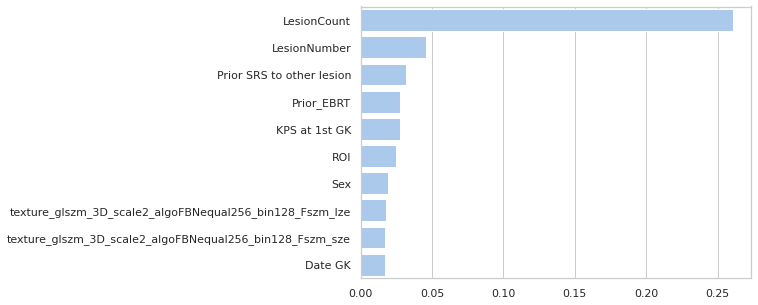

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 2 columns
The data size after processing is X: (7566, 6), y: (7566,).

The traing data size before resampling is (5674, 6)
The traing data size after resampling is (7773, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6873. 
              The recall score is 0.2983. 
              The Precision score is 0.3649. 
              The Accuracy is 0.8832.
              The log loss is 0.3759. 
              The f1 score is 0.3283.


In [23]:
gb_allored,result_allored,data_allored = red_model(df,gb_allo,data_allo,sampling = 'oversample')

## 3.3 ALL DATA: undersample

In [24]:
gb_allu,result_allu,data_allu = run_model(df,sampling='undersample')

The data size before processing is (8407, 1055).
--date encoded 1 columns
--label encoded 60 columns
The data size after processing is X: (6692, 374), y: (6692,).

The traing data size before resampling is (5019, 374)
The traing data size after resampling is (1410, 374)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.7909. 
              The recall score is 0.4639. 
              The Precision score is 0.3632. 
              The Accuracy is 0.8661.
              The log loss is 0.3368. 
              The f1 score is 0.4074.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


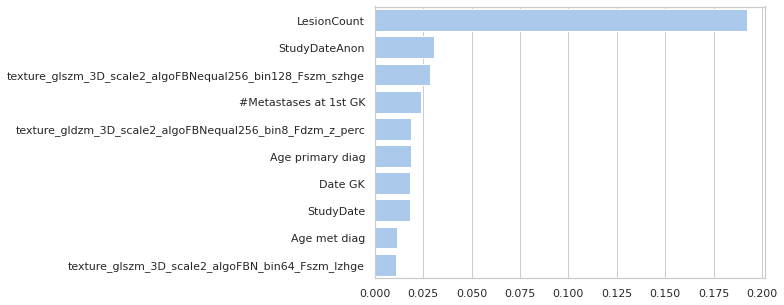

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 1 columns
The data size after processing is X: (7631, 6), y: (7631,).

The traing data size before resampling is (5723, 6)
The traing data size after resampling is (1479, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8516. 
              The recall score is 0.5899. 
              The Precision score is 0.3903. 
              The Accuracy is 0.8758.
              The log loss is 0.3203. 
              The f1 score is 0.4698.


In [25]:
gb_allured,result_allured,data_allured = red_model(df,gb_allu,data_allu,sampling = 'undersample')

# 4. Clinical Data
## 4.1 Without sampling

In [26]:
cols = []
for c in df.columns:
    if not (c.startswith('int') or 
            c.startswith('morph') or 
            c.startswith('texture')):
        cols.append(c)

df_c = df[cols]

In [27]:
gb_c,result_c,data_c = run_model(df_c,sampling='none')

The data size before processing is (8407, 58).
--date encoded 1 columns
--label encoded 11 columns
The data size after processing is X: (7309, 23), y: (7309,).

The traing data size before resampling is (5481, 23)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.9037. 
              The recall score is 0.3580. 
              The Precision score is 0.7342. 
              The Accuracy is 0.9316.
              The log loss is 0.1886. 
              The f1 score is 0.4813.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


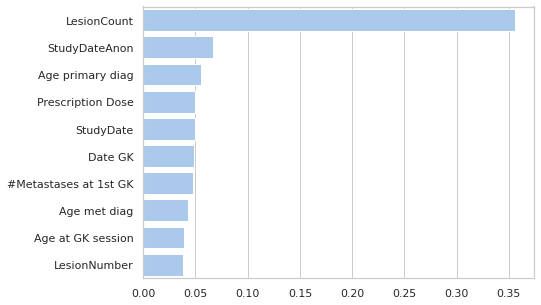

The data size before processing is (8407, 7).
--date encoded 1 columns
--label encoded 2 columns
The data size after processing is X: (7948, 6), y: (7948,).

The traing data size before resampling is (5961, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8729. 
              The recall score is 0.4294. 
              The Precision score is 0.6129. 
              The Accuracy is 0.9250.
              The log loss is 0.2751. 
              The f1 score is 0.5050.


In [28]:
gb_cred,result_cred,data_cred = red_model(df_c,gb_c,data_c,sampling = 'none')

## 4.2 Clinical: Oversample

In [29]:
gb_co,result_co,data_co = run_model(df_c,sampling='oversample')

The data size before processing is (8407, 58).
--date encoded 1 columns
--label encoded 11 columns
The data size after processing is X: (7309, 23), y: (7309,).

The traing data size before resampling is (5481, 23)
The traing data size after resampling is (7486, 23)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8968. 
              The recall score is 0.3642. 
              The Precision score is 0.5960. 
              The Accuracy is 0.9218.
              The log loss is 0.2034. 
              The f1 score is 0.4521.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


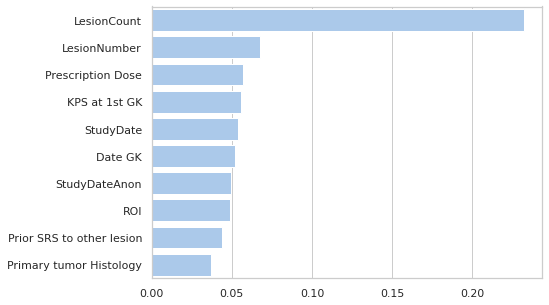

The data size before processing is (8407, 7).
--date encoded 1 columns
--label encoded 1 columns
The data size after processing is X: (7966, 6), y: (7966,).

The traing data size before resampling is (5974, 6)
The traing data size after resampling is (8220, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8102. 
              The recall score is 0.3296. 
              The Precision score is 0.5960. 
              The Accuracy is 0.9197.
              The log loss is 0.2433. 
              The f1 score is 0.4245.


In [30]:
gb_cored,result_cored,data_cored = red_model(df_c,gb_co,data_co,sampling = 'oversample')

## 4.3 Clinical: Undersample

In [31]:
gb_cu,result_cu,data_cu = run_model(df_c,sampling='undersample')

The data size before processing is (8407, 58).
--date encoded 1 columns
--label encoded 11 columns
The data size after processing is X: (7309, 23), y: (7309,).

The traing data size before resampling is (5481, 23)
The traing data size after resampling is (1470, 23)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8982. 
              The recall score is 0.6173. 
              The Precision score is 0.3788. 
              The Accuracy is 0.8764.
              The log loss is 0.2835. 
              The f1 score is 0.4695.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


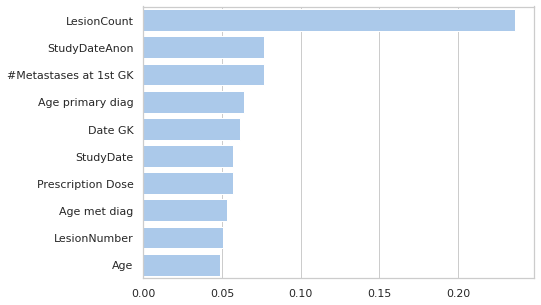

The data size before processing is (8407, 7).
--date encoded 1 columns
--label encoded 2 columns
The data size after processing is X: (7937, 6), y: (7937,).

The traing data size before resampling is (5952, 6)
The traing data size after resampling is (1503, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.8471. 
              The recall score is 0.5920. 
              The Precision score is 0.3344. 
              The Accuracy is 0.8610.
              The log loss is 0.3277. 
              The f1 score is 0.4274.


In [32]:
gb_cured,result_cured,data_cured = red_model(df_c,gb_cu,data_cu,sampling = 'undersample')

In [33]:
#pickle.dump(gb_c,open('GB_c_1.pkl','wb'))

# 5. Radiomic
## 5.1 Without sampling

In [34]:
cols = []
for c in df.columns:
    if c.startswith('intHist') or c.startswith('morph') or c.startswith('texture') or c == 'Failure-binary':
        cols.append(c)
df_r = df[cols]

In [35]:
gb_r,result_r,data_r = run_model(df_r,sampling='none')

The data size before processing is (8407, 990).
--date encoded 0 columns
--label encoded 49 columns
The data size after processing is X: (7631, 351), y: (7631,).

The traing data size before resampling is (5723, 351)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6314. 
              The recall score is 0.0110. 
              The Precision score is 0.6667. 
              The Accuracy is 0.9057.
              The log loss is 0.3525. 
              The f1 score is 0.0217.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


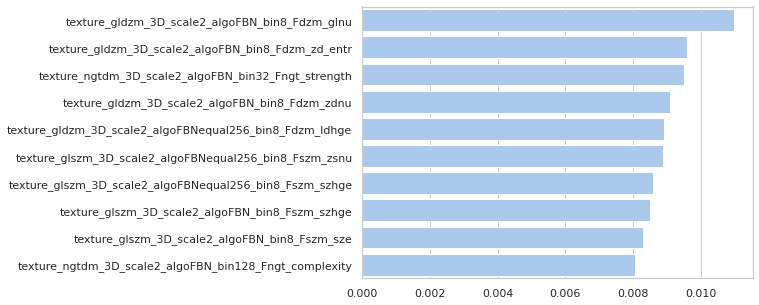

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 0 columns
The data size after processing is X: (8065, 6), y: (8065,).

The traing data size before resampling is (6048, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.5938. 
              The recall score is 0.0120. 
              The Precision score is 0.2500. 
              The Accuracy is 0.9157.
              The log loss is 0.2976. 
              The f1 score is 0.0230.


In [36]:
gb_rred,result_rred,data_rred = red_model(df_r,gb_r,data_r,sampling = 'none')

## 5.2 Radiomic: Oversample

In [37]:
gb_ro,result_ro,data_ro = run_model(df_r,sampling='oversample')

The data size before processing is (8407, 990).
--date encoded 0 columns
--label encoded 49 columns
The data size after processing is X: (7631, 351), y: (7631,).

The traing data size before resampling is (5723, 351)
The traing data size after resampling is (7866, 351)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6516. 
              The recall score is 0.0608. 
              The Precision score is 0.3143. 
              The Accuracy is 0.8983.
              The log loss is 0.5132. 
              The f1 score is 0.1019.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


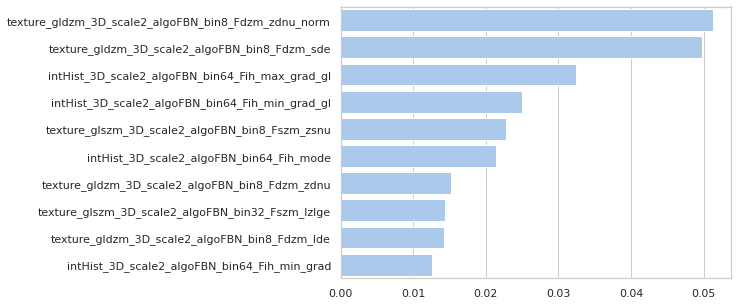

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 0 columns
The data size after processing is X: (8065, 6), y: (8065,).

The traing data size before resampling is (6048, 6)
The traing data size after resampling is (8313, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.5670. 
              The recall score is 0.1205. 
              The Precision score is 0.2105. 
              The Accuracy is 0.8904.
              The log loss is 0.3829. 
              The f1 score is 0.1533.


In [38]:
gb_rored,result_rored,data_rored = red_model(df_r,gb_ro,data_ro,sampling = 'oversample')

## 5.3 Radiomic: Undersample

In [39]:
gb_ru,result_ru,data_ru = run_model(df_r,sampling='undersample')

The data size before processing is (8407, 990).
--date encoded 0 columns
--label encoded 49 columns
The data size after processing is X: (7631, 351), y: (7631,).

The traing data size before resampling is (5723, 351)
The traing data size after resampling is (1437, 351)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6367. 
              The recall score is 0.3149. 
              The Precision score is 0.1869. 
              The Accuracy is 0.8050.
              The log loss is 0.4501. 
              The f1 score is 0.2346.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


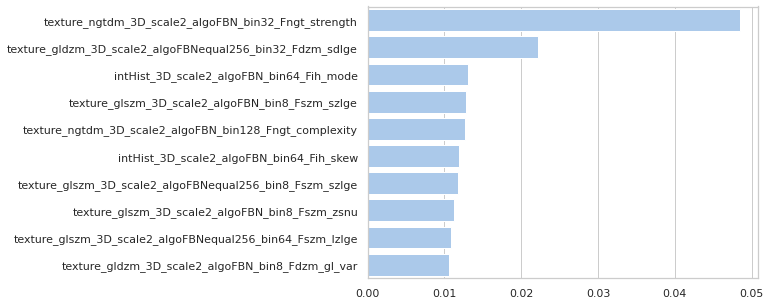

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 0 columns
The data size after processing is X: (7632, 6), y: (7632,).

The traing data size before resampling is (5724, 6)
The traing data size after resampling is (1455, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6624. 
              The recall score is 0.3029. 
              The Precision score is 0.2023. 
              The Accuracy is 0.8265.
              The log loss is 0.4460. 
              The f1 score is 0.2426.


In [40]:
gb_rured,result_rured,data_rured = red_model(df_r,gb_ru,data_ru,sampling = 'undersample')

In [41]:
#pickle.dump(gb_r,open('GB_r_1.pkl','wb'))

## 5.4 Remove '_error'

In [42]:
cols = []
for c in df.columns:
    if not c.endswith('error'):
        if c.startswith('intHist') or c.startswith('morph') or c.startswith('texture') or c == 'Failure-binary':
            cols.append(c)
df_rr = df[cols]

gb_re,result_re,data_re = run_model(df_rr,sampling='none')

The data size before processing is (8407, 893).
--date encoded 0 columns
--label encoded 0 columns
The data size after processing is X: (7632, 302), y: (7632,).

The traing data size before resampling is (5724, 302)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6339. 
              The recall score is 0.0057. 
              The Precision score is 0.2000. 
              The Accuracy is 0.9067.
              The log loss is 0.3214. 
              The f1 score is 0.0111.


/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


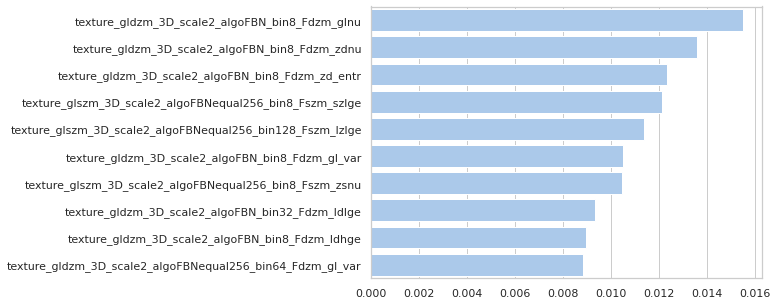

The data size before processing is (8407, 7).
--date encoded 0 columns
--label encoded 0 columns
The data size after processing is X: (8065, 6), y: (8065,).

The traing data size before resampling is (6048, 6)

--fitting cross validation..
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--fitting the final model..
 Results:
              The ROC_AUC score is 0.6125. 
              The recall score is 0.0120. 
              The Precision score is 0.6667. 
              The Accuracy is 0.9182.
              The log loss is 0.2880. 
              The f1 score is 0.0237.


In [43]:
gb_rer,result_rer,data_rer = red_model(df_rr,gb_re,data_re,sampling = 'none')

# 6. Result

In [44]:
result_agg = [result_all,result_allo,result_allu,
              result_allred,result_allored,result_allured,
              result_c,result_co,result_cu,
              result_cred,result_cored,result_cured,
              result_r,result_ro,result_ru,
             result_rred,result_rored,result_rured,
             result_re,result_rer]
cols = ['roc_auc','recall','precision','log_loss','f1','accuracy']
ind = ['all','all_oversample','all_undersample',
       'all_red','all_oversample_red','all_undersample_red',
       'clinical_all','clinical_oversample','clinical_undersample',
       'clinical_all_red','clinical_oversample_red','clinical_undersample_red',
       'radiomic_all','radiomic_oversample','radiomic_undersample',
       'radiomic_all_red','radiomic_oversample_red','radiomic_undersample_red',
      'radiomic_remove_error','radiomic_remove_error_red']

In [45]:
result_df = pd.DataFrame(result_agg,columns=cols,index = ind)

In [46]:
result_df

,roc_auc,recall,precision,log_loss,f1,accuracy
all,0.805970,0.271084,0.789474,0.266222,0.403587,0.920502
all_oversample,0.802248,0.277108,0.730159,0.445196,0.401747,0.918111
all_undersample,0.790903,0.463855,0.363208,0.336774,0.407407,0.866109
all_red,0.869900,0.298429,0.750000,0.218428,0.426966,0.926689
all_oversample_red,0.687285,0.298343,0.364865,0.375904,0.328267,0.883192
all_undersample_red,0.851578,0.589888,0.390335,0.320332,0.469799,0.875786
clinical_all,0.903660,0.358025,0.734177,0.188586,0.481328,0.931619
clinical_oversample,0.896816,0.364198,0.595960,0.203355,0.452107,0.921772
clinical_undersample,0.898193,0.617284,0.378788,0.283453,0.469484,0.876368
clinical_all_red,0.872938,0.429379,0.612903,0.275084,0.504983,0.925013


In [47]:
result_df.to_csv('result.csv')

In [48]:
# clinical + image
# clinical + radiomic
# clinical


##5/6 most important features